In [3]:
# Read the data

import pandas as pd

dftrain = pd.read_csv('./Drugs/drugsComTrain_raw.tsv', delimiter='\t')
dftest = pd.read_csv('./Drugs/drugsComTest_raw.tsv', delimiter='\t')

In [4]:
# Take a look

dftrain.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [5]:
# Extract the review and rating columns

train_samples = dftrain['review'].values.tolist()
train_labels = dftrain['rating'].values
test_samples = dftest['review'].values.tolist()
test_labels = dftest['rating'].values

In [6]:
# Build up the word index (only 5000 most common words)

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(train_samples)

In [7]:
# Convert reviews to integer sequences

train_sequences = tokenizer.texts_to_sequences(train_samples)
test_sequences = tokenizer.texts_to_sequences(test_samples)
print(train_sequences[0])

[5, 38, 28, 35, 197, 1, 45, 5, 15, 848, 12, 2922, 99, 150, 2, 3806, 1551]


In [8]:
# Pad the reviews to have the same length

from tensorflow.keras import preprocessing

maxlen = 100

train_sequences = preprocessing.sequence.pad_sequences(train_sequences, maxlen = maxlen)
test_sequences = preprocessing.sequence.pad_sequences(test_sequences, maxlen = maxlen)
print(train_sequences[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    5
   38   28   35  197    1   45    5   15  848   12 2922   99  150    2
 3806 1551]


In [9]:
# Preprocess the multiclass labels to one-hot form

from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

print(train_labels[:5])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [10]:
# Remove the excess column

train_labels = train_labels[:,1:]
test_labels = test_labels[:,1:]

print(train_labels.shape, test_labels.shape)

(161297, 10) (53766, 10)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, SimpleRNN

In [12]:
# Use word vectors of dimension 16, flatten and feed straight to output layer

model = Sequential()
model.add(Embedding(5000, 16, input_length = maxlen))
model.add(Flatten())
model.add(Dense(10, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           80000     
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                16010     
Total params: 96,010
Trainable params: 96,010
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Compile the model

model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])

In [14]:
# Train the model

history = model.fit(train_sequences, train_labels, epochs = 5, batch_size=32, validation_split = 0.2)

Train on 129037 samples, validate on 32260 samples
Epoch 1/5
129037/129037 [==============================] - 14s 109us/sample - loss: 1.7114 - acc: 0.3971 - val_loss: 1.6223 - val_acc: 0.4255
Epoch 2/5
129037/129037 [==============================] - 11s 86us/sample - loss: 1.5482 - acc: 0.4540 - val_loss: 1.5998 - val_acc: 0.4349
Epoch 3/5
129037/129037 [==============================] - 11s 88us/sample - loss: 1.4668 - acc: 0.4889 - val_loss: 1.5997 - val_acc: 0.4427
Epoch 4/5
129037/129037 [==============================] - 11s 84us/sample - loss: 1.4012 - acc: 0.5170 - val_loss: 1.6083 - val_acc: 0.4428
Epoch 5/5
129037/129037 [==============================] - 11s 83us/sample - loss: 1.3494 - acc: 0.5375 - val_loss: 1.6301 - val_acc: 0.4426


In [15]:
# Plot the training progress, first the loss function ...

import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<Figure size 640x480 with 1 Axes>

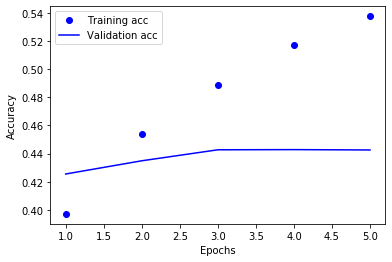

In [16]:
# ... and the accuracy.

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
# Evaluate with test data

model.evaluate(test_sequences, test_labels)

53766/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[1.6355124848613434, 0.44163597]

In [18]:
# Try another model, this time with RNN structure

model = Sequential()
model.add(Embedding(5000, 16))
model.add(SimpleRNN(16))
model.add(Dense(10, activation = 'softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          80000     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                170       
Total params: 80,698
Trainable params: 80,698
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])

In [20]:
model.fit(train_sequences, train_labels, epochs = 5, batch_size=32, validation_split=0.2)

Train on 129037 samples, validate on 32260 samples
Epoch 1/5
129037/129037 [==============================] - 120s 930us/sample - loss: 1.8345 - acc: 0.3677 - val_loss: 1.8525 - val_acc: 0.3707
Epoch 2/5
129037/129037 [==============================] - 125s 967us/sample - loss: 1.6782 - acc: 0.4113 - val_loss: 1.7065 - val_acc: 0.41023 - acc: 
Epoch 3/5
129037/129037 [==============================] - 136s 1ms/sample - loss: 1.6263 - acc: 0.4252 - val_loss: 1.6841 - val_acc: 0.40201  - ETA: 3s - loss: 1.6263 
Epoch 4/5
129037/129037 [==============================] - 158s 1ms/sample - loss: 1.5897 - acc: 0.4387 - val_loss: 1.6451 - val_acc: 0.4173
Epoch 5/5
129037/129037 [==============================] - 182s 1ms/sample - loss: 1.5620 - acc: 0.4484 - val_loss: 1.6399 - val_acc: 0.4174ETA: 0s - loss: 1.5620 - acc: 0.4


In [21]:
model.evaluate(test_sequences, test_labels)

53766/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[1.6434101228340083, 0.41699216]